<div class="alert alert-info"><h1>Traffic Analysis</h1>
<p><b><i>Goal</i></b>: Analyze traffic patterns to identify rush hours, anomal patterns etc

In [1]:
import pandas as pd
import math
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sqlalchemy.dialects.mssql.information_schema import sequences

In [2]:
data = pd.read_csv('traffic.csv')
# Anpassungen / Preprocessing
data['DateTime'] = pd.to_datetime(data['DateTime'])
data = data.drop(['ID'], axis=1)
data.head()

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 01:00:00,1,13
2,2015-11-01 02:00:00,1,10
3,2015-11-01 03:00:00,1,7
4,2015-11-01 04:00:00,1,9


In [3]:
df = data.copy()
df.head()

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 01:00:00,1,13
2,2015-11-01 02:00:00,1,10
3,2015-11-01 03:00:00,1,7
4,2015-11-01 04:00:00,1,9


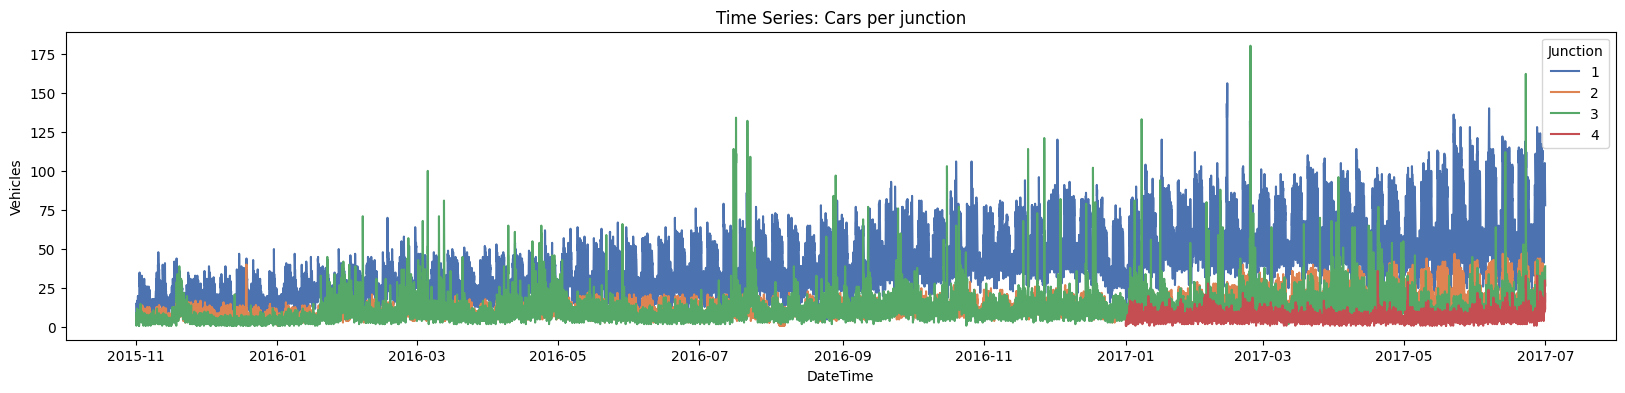

In [4]:
plt.figure(figsize=(20, 4))
sns.lineplot(data=df, x='DateTime', y='Vehicles', hue='Junction', palette='deep')
plt.title('Time Series: Cars per junction')

plt.show()


<div class="alert alert-info"><h2>Feature Engineering: Create Features to inspect 

In [5]:
df['year'] = df['DateTime'].dt.year
df['month']= df['DateTime'].dt.month
df['date_no'] = df['DateTime'].dt.day
df['hour'] = df['DateTime'].dt.hour
df['day'] = df.DateTime.dt.strftime('%A')
df.head()

,DateTime,Junction,Vehicles,year,month,date_no,hour,day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


<div class="alert alert-info"><h2>Inspect the newly generated Features via plot

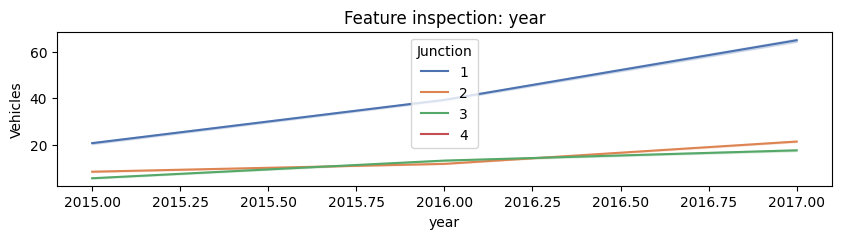

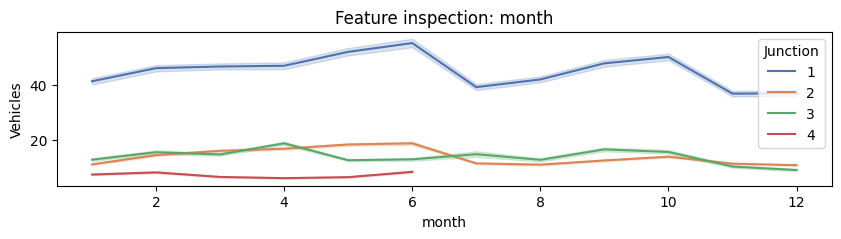

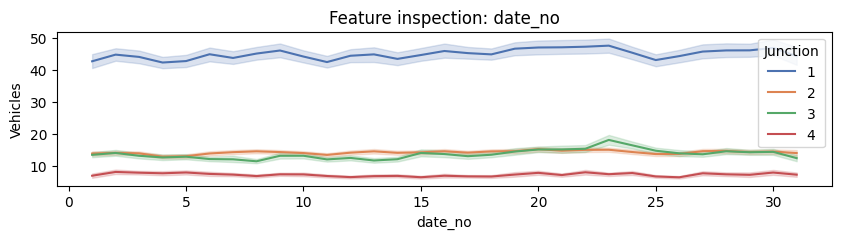

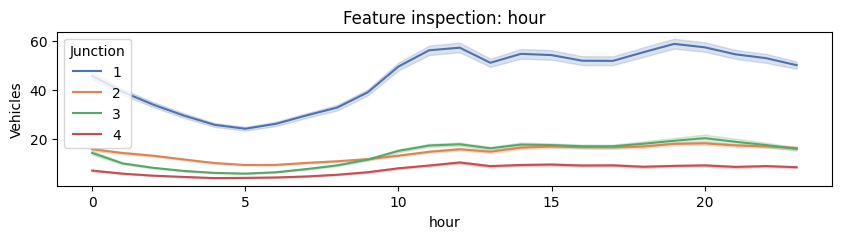

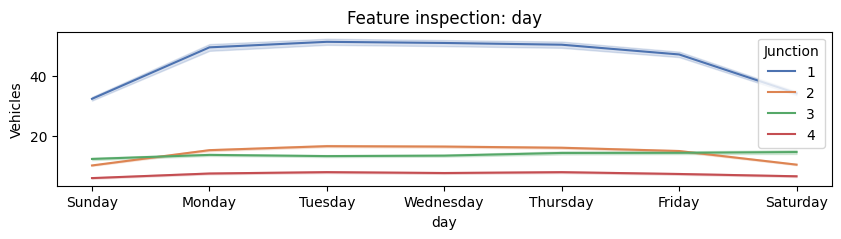

In [6]:
features = ['year', 'month', 'date_no', 'hour', 'day']

for i in features:
    plt.figure(figsize=(10, 2))
    ax = sns.lineplot(data=df, x=i, y='Vehicles', hue='Junction', palette='deep')
    ax.set_title(f'Feature inspection: {i}')

<div class="alert alert-info"><h2>Correlation analysis

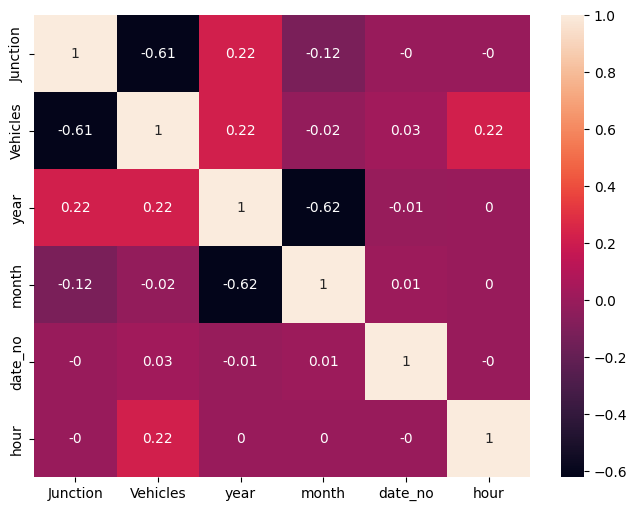

In [7]:
corrmat = df.drop(columns=['day', 'DateTime']).corr().round(2)
plt.figure(figsize=(8, 6))
sns.heatmap(corrmat, annot=True)
plt.show()

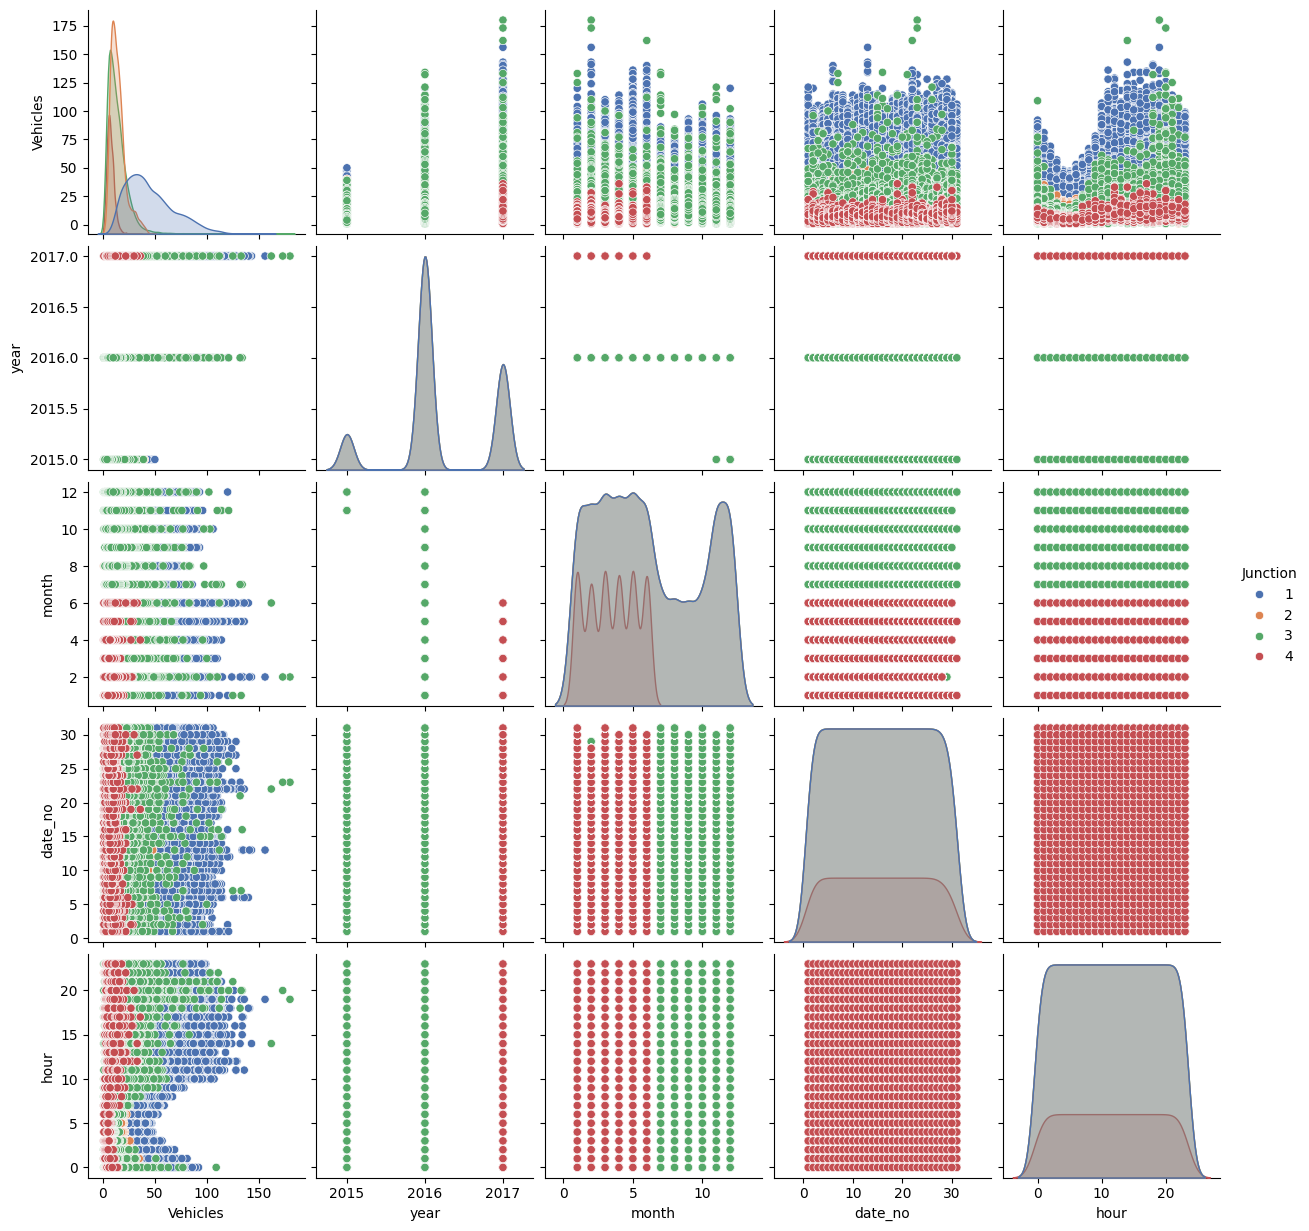

In [8]:
sns.pairplot(data=df, hue='Junction', palette='deep')
plt.show()

In [9]:
piv = data.pivot(columns='Junction', index='DateTime')
#piv.describe()

df_1 = piv[[('Vehicles', 1)]]
df_2 = piv[[('Vehicles', 2)]]
df_3 = piv[[('Vehicles', 3)]]
df_4 = piv[[('Vehicles', 4)]]
df_4 = df_4.dropna()

df_1

,Vehicles
Junction,1
DateTime,
2015-11-01 00:00:00,15.0
2015-11-01 01:00:00,13.0
2015-11-01 02:00:00,10.0
2015-11-01 03:00:00,7.0
2015-11-01 04:00:00,9.0
...,...
2017-06-30 19:00:00,105.0
2017-06-30 20:00:00,96.0


In [10]:
list_dfs = [df_1, df_2, df_3, df_4]

"""for i in list_dfs:
    i.columns = i.columns.droplevel(level=1)"""



'for i in list_dfs:\n    i.columns = i.columns.droplevel(level=1)'

<div class="alert alert-info"><h3>Function for subplots

In [11]:
sns.color_palette("Set2", 4)

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]

In [12]:
colors = sns.color_palette("Set2", 4)


def subplots4(dataframes, title, colors):
    fig, axes = plt.subplots(len(dataframes), 1, figsize=(15, 12), sharey=True)
    fig.suptitle(title)
    plt.subplots_adjust(hspace=0.4)
    
    for idx, (df, c) in enumerate(zip(dataframes, colors)):
        sns.lineplot(data=df, ax=axes[idx], color=c)
        axes[idx].set_title(f'Junction {idx + 1}')

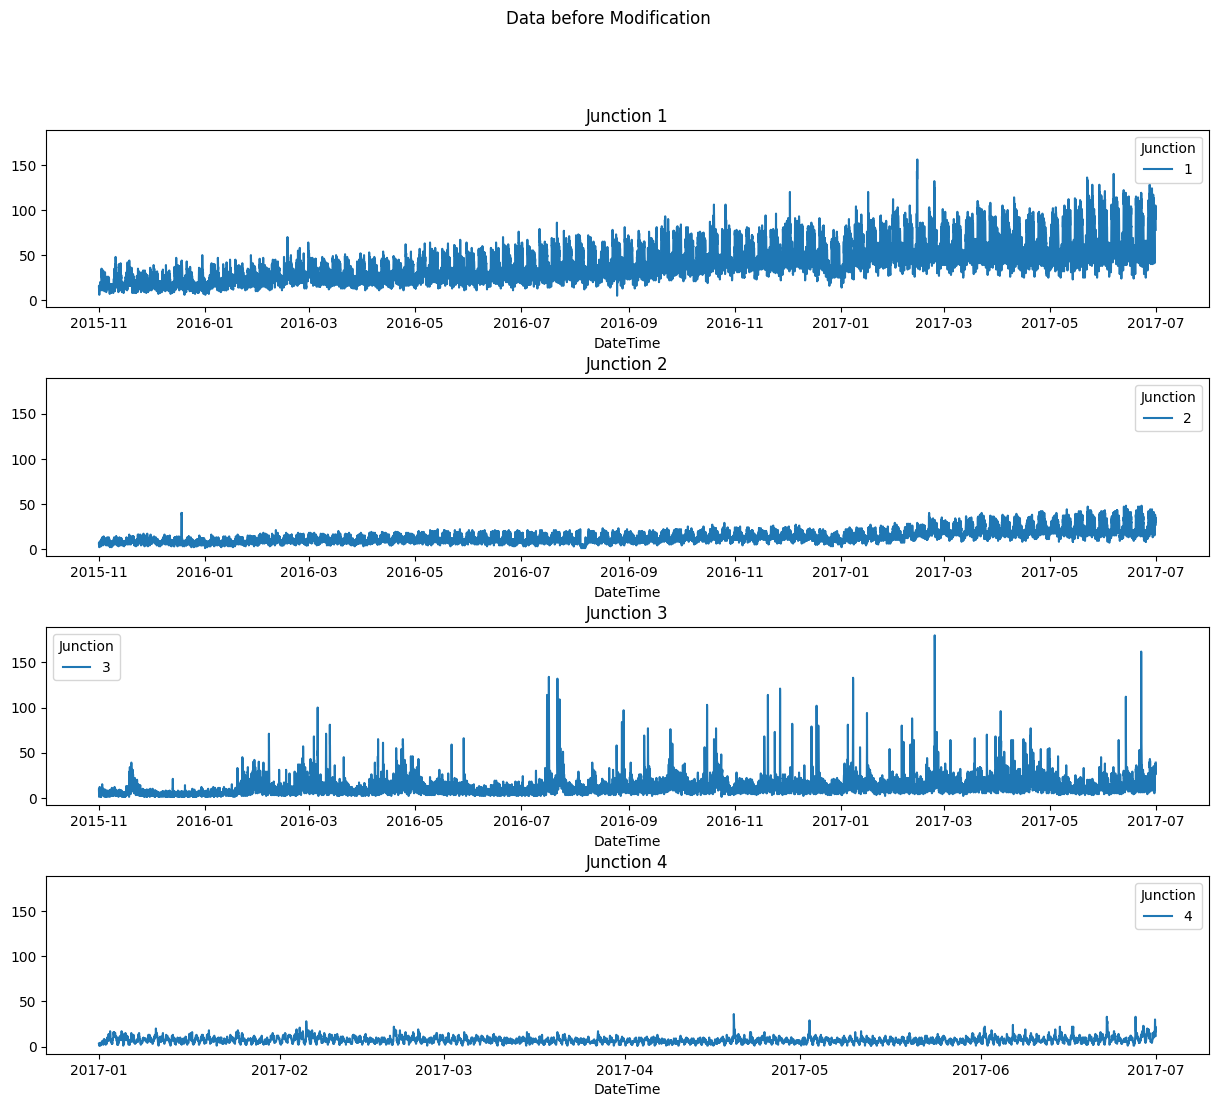

In [13]:
dataframes = [df_1.Vehicles, df_2.Vehicles, df_3.Vehicles, df_4.Vehicles]
subplots4(dataframes, 'Data before Modification', colors)


<div class="alert alert-info"><h2>Problem with time series: no seasonality </h2>
<h3>therefore: <i> Normalize / Standardize </i> </h3>
<p><b> Hintergrund zum Standardisieren / Differenzieren</b>: Statistische Werte der Zeitreihe müssen über die Zeit konstant sein.<br> <i>Normalisiere</i>, wenn die Daten saisonale Muster aufweisen.<br><i> Standardisiere</i>, wenn die Veränderung von Werten relevanter ist, als die Absolutwerte (Bsp Aktienkurs)

In [14]:
from sklearn.preprocessing import StandardScaler

def normalize(df, col):
    scaler = StandardScaler()
    df_normalized = scaler.fit_transform(df[[col]])
    df_normalized = pd.DataFrame(df_normalized, columns=[col])

    return df_normalized, scaler.mean_, scaler.scale_[0] # Mittelwert und Standardabweichung


def difference(df, col, interval):
    diff = []
    for i in range(interval, len(df)):
        val = df[col][i] - df[col][i - interval]
        diff.append(val)
    return diff

## Intervals:
- `Junction 1`: _Weekly interval_
- `Junction 2`: _daily intervals_
- `Junction 3`, `Junction 4`: _Hourly_

In [15]:
def process_dataframe(df, col, interval):
    df_norm, mean, std = normalize(df, col)

    diff = difference(df_norm, col=col, interval=interval)
    df_norm = df_norm[interval:]
    df_norm.index = df.index[interval:]  # Beibehaltung des ursprünglichen Indexes

    df_norm['Diff'] = diff
    return df_norm, mean, std

In [16]:
dfs = [df_1, df_2, df_3, df_4]
intervals = [24*7, 24, 1, 1]
processed_dfs = []
avgs = []
stds = []

for df, interval in zip(dfs, intervals):
    processed_df, mean, std = process_dataframe(df, col='Vehicles', interval=interval)
    processed_dfs.append(processed_df)
    avgs.append(mean)
    stds.append(stds)

df_N1, df_N2, df_N3, df_N4 = processed_dfs
avg_J1, avg_J2, avg_J3, avg_J4 = avgs
std_J1, std_J2, std_J3, std_J4 = stds


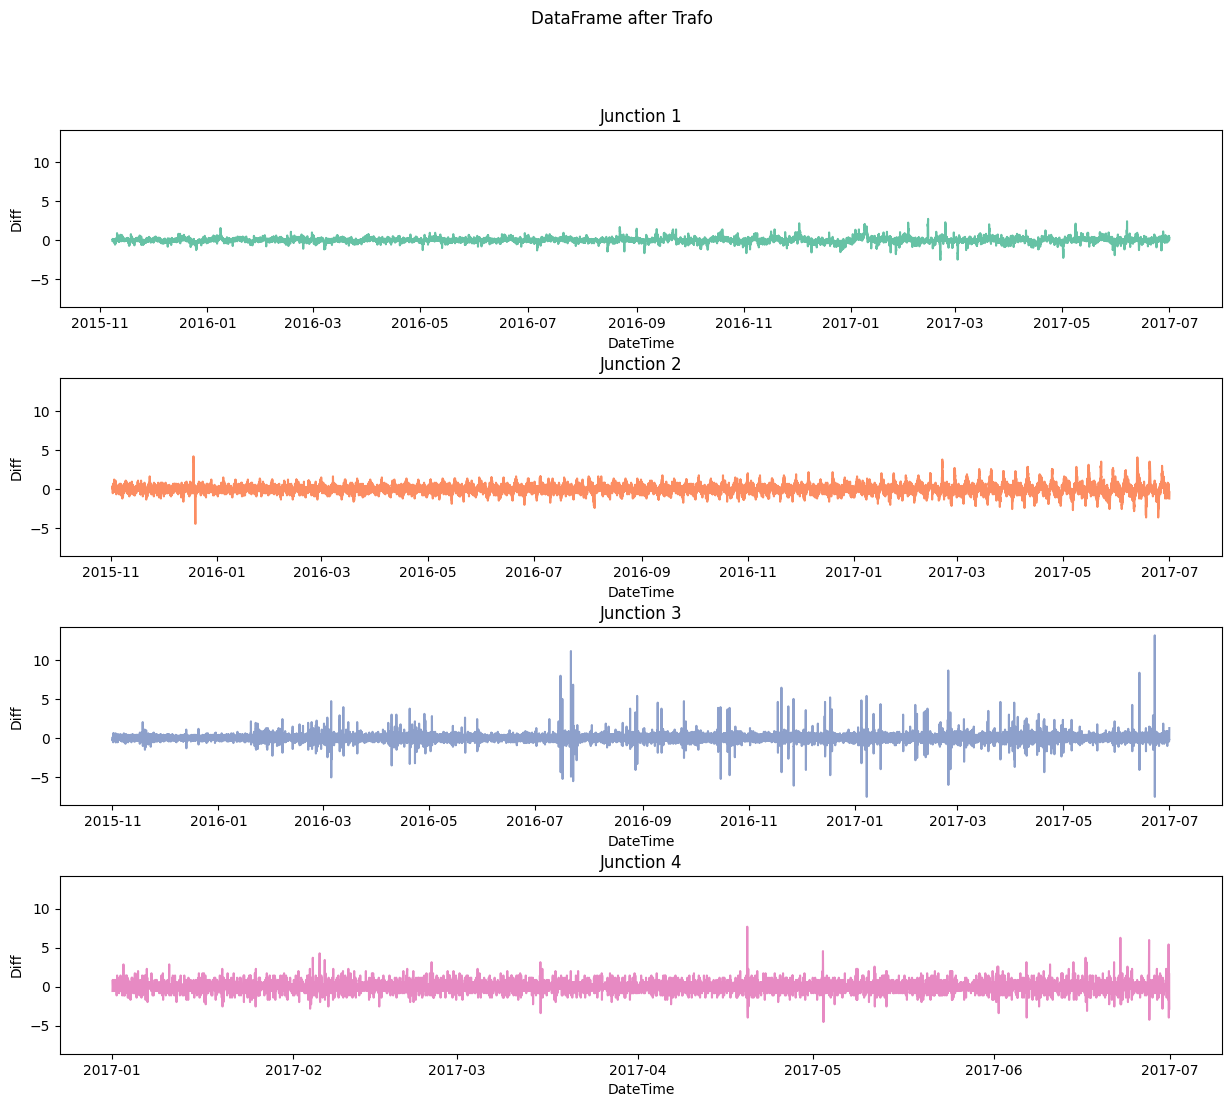

In [17]:
subplots4([df_N1.Diff, df_N2.Diff, df_N3.Diff, df_N4.Diff], 'DataFrame after Trafo', colors=colors)

In [18]:
from statsmodels.tsa.stattools import adfuller

dfs_Diff = [df_N1.Diff, df_N2.Diff, df_N3.Diff, df_N4.Diff]



def stationary_check(df):
    check = adfuller(df.dropna()) 
    for key, value in check[4].items():
        if check[0] > check[4]["1%"]:
            print('Time Series is NOT Stationary')
        else:
            print('Time Series IS Stationary')

for i in dfs_Diff:
    stationary_check(i)
    


Time Series IS Stationary
Time Series IS Stationary
Time Series IS Stationary
Time Series IS Stationary
Time Series IS Stationary
Time Series IS Stationary
Time Series IS Stationary
Time Series IS Stationary
Time Series IS Stationary
Time Series IS Stationary
Time Series IS Stationary
Time Series IS Stationary


<div class="alert alert-success"><h2>Time series successfully transformed to stationary values!

In [19]:
dfs_nona = []
for df_N in dfs_Diff:
    df_J = df_N.dropna().to_frame()
    dfs_nona.append(df_J)

df_J1, df_J2, df_J3, df_J4 = dfs_nona

<div class="alert alert-info"><h2>Create the model: </h2>
<h3>1. Divide Data into Train / Test

In [20]:
df_J1.head()

,Diff
DateTime,
2015-11-08 00:00:00,-0.086928
2015-11-08 01:00:00,0.130392
2015-11-08 02:00:00,0.043464
2015-11-08 03:00:00,0.043464
2015-11-08 04:00:00,0.043464


In [21]:
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

In [22]:
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

<div class="alert alert-success"><h2>Train_test_Split finished</h2> 
<h3>Now: Train a Model (GRU)

<div class="alert alert-info"><h1> GRU (<b>G</b>ated <b>R</b>ecurrent <b>U</b>nit)</h1>
<p> Ein GRU (Gated Recurrent Unit) ist eine Art rekurrentes neuronales Netzwerk (RNN), das für Zeitreihenanalysen und sequenzielle Daten wie deine Daten verwendet wird</p>

### Grundaufbau eines GRU-Modells:

1. **Datenvorbereitung**: 
   - Deine Eingabedaten (Features) und Zielwerte (`y`) müssen zuerst in die richtige Form gebracht werden, um sie in das Modell zu füttern. Normalerweise werden die Daten als 3D-Tensoren im Format `(Batch_Size, Sequence_Length, Input_Size)` eingegeben. 
   - Batch_Size: Anzahl der Beispiele im Batch (z.B. 32 oder 64).
   - Sequence_Length: Länge der Zeitfenster, z.B. 32 Zeitpunkte.
   - Input_Size: Anzahl der Merkmale für jeden Zeitschritt (z.B. 1 für einfache Zeitreihen).

2. **GRU-Schichten**:
   - Eine **GRU-Schicht** hat zwei Hauptbestandteile: einen Update-Gate und einen Reset-Gate. Diese steuern, wie die Informationen von einem Zeitschritt zum nächsten weitergegeben werden. Eine GRU hat weniger Parameter als ein LSTM und wird daher manchmal als effizienter angesehen.
   
   In deinem Fall haben wir mehrere GRU-Schichten, die nacheinander gestapelt werden, um komplexere Muster in den Daten zu lernen.

3. **Dropout**:
   - Dropout ist eine Regularisierungstechnik, die hilft, Overfitting zu verhindern, indem sie zufällig einige Verbindungen während des Trainings "abschaltet". In deinem Modell wird Dropout nach jeder GRU-Schicht angewendet.

4. **Dense-Schicht**:
   - Eine **Dense-Schicht** (auch als Fully Connected Layer bekannt) wird verwendet, um die Ausgabe der letzten GRU-Schicht in eine finale Vorhersage umzuwandeln. In diesem Fall gibt die Dense-Schicht einen Wert zurück, was darauf hindeutet, dass es sich um ein Regressionsproblem handelt.

5. **Optimierer und Verlustfunktion**:
   - Der **SGD-Optimierer (Stochastic Gradient Descent)** wird verwendet, um die Gewichtungen des Netzwerks zu aktualisieren und das Modell zu trainieren.
   - Die **Mean Squared Error (MSE)** Verlustfunktion wird verwendet, um die Differenz zwischen den tatsächlichen und den vorhergesagten Werten zu berechnen.


### Erklärung der wichtigsten Teile:

1. **GRU-Schicht**:
   ```python
   self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
   ```
   - `input_size`: Die Anzahl der Merkmale in jedem Zeitstempel (in deinem Fall 1, weil du nur eine Zeitreihe hast).
   - `hidden_size`: Die Anzahl der Neuronen in den verborgenen Schichten. In deinem Fall 150.
   - `num_layers`: Die Anzahl der GRU-Schichten im Modell (hier 3).
   - `batch_first=True`: Das bedeutet, dass der Input in der Form `(batch_size, seq_len, input_size)` erwartet wird.

2. **Dense-Schicht**:
   ```python
   self.fc = nn.Linear(hidden_size, 1)
   ```
   - Diese Schicht nimmt die Ausgabe der letzten GRU-Zelle (nach der letzten Zeiteinheit) und gibt den finalen Vorhersagewert zurück.

3. **Forward-Methode**:
   ```python
   def forward(self, x):
       h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
       out, _ = self.gru(x, h0)
       out = self.fc(out[:, -1, :])
       return out
   ```
   - Zuerst wird der Anfangszustand der GRU (`h0`) auf null gesetzt.
   - Die Eingabedaten `x` werden dann durch die GRU-Schicht geleitet, und die Ausgabe wird mit der Dense-Schicht verarbeitet, um das Endergebnis zu berechnen.
   - `out[:, -1, :]` nimmt nur die Ausgabe des letzten Zeitpunkts, da du den Wert am letzten Zeitschritt vorhersagen möchtest.

4. **Training**:
   - In der Trainingsschleife berechnen wir den Verlust (`loss`), führen eine Rückpropagation (`loss.backward()`) durch und optimieren das Modell, indem wir die Gewichtungen mit `optimizer.step()` aktualisieren.

---

### Zusammenfassung:
- **GRU-Schicht:** Der Kern des Modells, das die zeitlichen Beziehungen lernt.
- **Dropout:** Regularisierung, die hilft, Überanpassung zu verhindern.
- **Dense-Schicht:** Wandelt die Ausgabe der letzten GRU-Zelle in einen einzelnen Vorhersagewert um.
- **Optimierer und Verlustfunktion:** Verantwortlich für das Anpassen der Modellparameter basierend auf den Fehlern.


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

# GRU-Modell
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size=1):
        super(GRUModel, self).__init__()
        self.gru1 = nn.GRU(input_size=input_size, hidden_size=hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.gru2 = nn.GRU(input_size=hidden_size1, hidden_size=hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.gru3 = nn.GRU(input_size=hidden_size2, hidden_size=hidden_size3, batch_first=True)
        self.dropout3 = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x, _ = self.gru1(x)
        x = self.dropout1(x)
        x, _ = self.gru2(x)
        x = self.dropout2(x)
        x, _ = self.gru3(x)
        x = self.dropout3(x)
        x = self.fc(x[:, -1, :])  # Nur die letzte Zeitschritt-Ausgabe
        return x

# GRU-Training und Vorhersage: Mehr Epochen und verringerte Batch SIze
def GRU_model(X_Train, y_Train, X_Test, y_Test=None, epochs=100, batch_size=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Tensor-Daten erstellen
    X_Train_tensor = torch.tensor(X_Train, dtype=torch.float32).to(device)
    y_Train_tensor = torch.tensor(y_Train, dtype=torch.float32).unsqueeze(-1).to(device)
    X_Test_tensor = torch.tensor(X_Test, dtype=torch.float32).to(device)
    y_Test_tensor = torch.tensor(y_Test, dtype=torch.float32).unsqueeze(-1).to(device)

    # Modell initialisieren
    # First try: hidden_sizes 64, 32, 16
    model = GRUModel(input_size=1, hidden_size1=64, hidden_size2=32, hidden_size3=16).to(device)
    # neuer optimizer: AdamW statt Adam
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Training
    model.train()

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(X_Train_tensor)
        loss = criterion(predictions, y_Train_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)


        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(X_Test_tensor).cpu().numpy()

    if y_Test is not None:
        rmse = RMSE_Value(y_Test, predictions)
        print(f"RMSE: {rmse}")
    return predictions

# RMSE-Berechnung
def RMSE_Value(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    return rmse


In [24]:
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5))
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color=colors[m+1],label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [25]:
PredJ1 = GRU_model(X_trainJ1, y_trainJ1, X_testJ1, y_testJ1)


Using device: cuda
Epoch 1/100, Loss: 0.101030
Epoch 11/100, Loss: 0.082938
Epoch 21/100, Loss: 0.061850
Epoch 31/100, Loss: 0.058604
Epoch 41/100, Loss: 0.056187
Epoch 51/100, Loss: 0.053105
Epoch 61/100, Loss: 0.051209
Epoch 71/100, Loss: 0.049492
Epoch 81/100, Loss: 0.049014
Epoch 91/100, Loss: 0.047872
RMSE: 0.24123999706900415


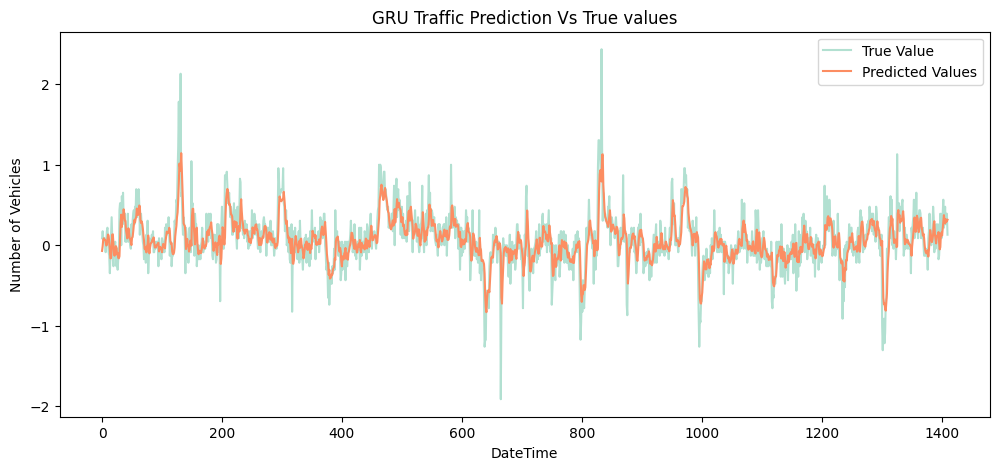

In [27]:
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

<div class="alert alert-success"><h2>Model build successfully</h2>
<p> <i>Save Model structure for further usage

In [33]:
model = GRUModel(input_size=1, hidden_size1=64, hidden_size2=32, hidden_size3=16).to(device="cuda")

torch.save(model, "grumodel.pth")

In [34]:
model_load_test = torch.load("grumodel.pth")



__main__.GRUModel